<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/Classification_with_resnet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

###Load data from pkl file

In [3]:
df = pd.read_pickle("/content/drive/MyDrive/full_preprocess_data.pkl")

In [4]:
df.head(5)

,Participant,Handedness,Finger,Task,Matrix,Timestamp,BlobCoords,BlobCount,Blobs,BlobImage,BlobImgFlattened
16,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194856,"[(10, 14, 13, 17)]",1,"[[[0, 4, 9, 1], [4, 31, 48, 10], [9, 150, 215,...","[[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194856,"[(10, 14, 13, 17)]",1,"[[[0, 4, 9, 1], [4, 31, 48, 10], [9, 150, 215,...","[[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194926,"[(10, 14, 14, 18)]",1,"[[[1, 17, 27, 5], [6, 105, 140, 27], [18, 161,...","[[1, 17, 27, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 17, 27, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
19,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194997,"[(10, 14, 13, 18)]",1,"[[[1, 7, 9, 1], [2, 31, 52, 10], [10, 168, 231...","[[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194997,"[(10, 14, 13, 18)]",1,"[[[1, 7, 9, 1], [2, 31, 52, 10], [10, 168, 231...","[[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


###View the data


In [5]:
df['Finger'].unique()

array(['little', 'middle', 'ring', 'thumb', 'index'], dtype=object)

In [6]:
df['Task'].unique()

array(['TAP', 'DRAG', 'SCROLL'], dtype=object)

In [7]:
df['Participant'].unique()

array([ 3, 12, 19,  9, 17,  6, 14,  8,  1, 11,  4, 16,  2, 10, 15, 13, 18,
        7, 20,  5])

###Split the participant id train

In [8]:
np.random.seed(11)
participant_id = df['Participant'].unique()
size = int(len(participant_id)*0.8)
participant_id_train = np.random.choice(participant_id, size = size, replace = False)
participant_id_train

array([ 9,  6,  4, 14, 15,  5, 13, 11, 20, 17, 16,  3,  1, 19,  8, 12])

In [9]:
Handedness = df['Handedness'].unique()
Finger = df['Finger'].unique()
Handedness, Finger

(array(['right', 'left'], dtype=object),
 array(['little', 'middle', 'ring', 'thumb', 'index'], dtype=object))

###Encoder and add label column

In [10]:
num = 0
dict_data = {}
for i in range (0,len(Handedness)):
  for j in range(0,len(Finger)):
    dict_temp = {Handedness[i] + ' ' + Finger[j] : num}
    dict_data.update(dict_temp)
    num = num + 1
dict_data

{'right little': 0,
 'right middle': 1,
 'right ring': 2,
 'right thumb': 3,
 'right index': 4,
 'left little': 5,
 'left middle': 6,
 'left ring': 7,
 'left thumb': 8,
 'left index': 9}

In [11]:
def get_feature_column (handedness, finger):
  c = handedness + ' ' + finger
  return dict_data[c]

df['label'] = [get_feature_column(df.Handedness.iloc[i], df.Finger.iloc[i]) for i in range (len(df))]

In [12]:
df['label'].unique()

array([0, 6, 7, 3, 4, 2, 1, 8, 5, 9])

In [13]:
def get_data(ones_train,ones_test, dframe, i):
  for i in range(len(dframe)):
    temp = int(dframe.iloc[[i]].Participant)
    if (temp == participant_id_train).any():
      arr_train = np.array(dframe.iloc[[i]].Blobs)
      arr_train = arr_train[0][0].astype(np.uint8)
      arr_train = cv2.resize(arr_train, (16, 16), interpolation=cv2.INTER_NEAREST)
      if(type(ones_train) is str):
        ones_train = [arr_train]
      else:
        ones_train.extend([arr_train])
    else:
      arr_test = np.array(dframe.iloc[[i]].Blobs)
      arr_test = arr_test[0][0].astype(np.uint8)
      arr_test = cv2.resize(arr_test, (16, 16), interpolation=cv2.INTER_NEAREST)
      if(type(ones_test) is str):
        ones_test = [arr_test]
      else:
        ones_test.extend([arr_test])
  return ones_train, ones_test
X_train = ""
X_test = ""
i = 0
X_train, X_test = get_data(X_train, X_test, df,i)

<ipython-input-13-94b120960f0e>:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  temp = int(dframe.iloc[[i]].Participant)


In [14]:
X_train[0]

array([[  0,   0,   0,   0,   4,   4,   4,   4,   9,   9,   9,   9,   1,
          1,   1,   1],
       [  0,   0,   0,   0,   4,   4,   4,   4,   9,   9,   9,   9,   1,
          1,   1,   1],
       [  0,   0,   0,   0,   4,   4,   4,   4,   9,   9,   9,   9,   1,
          1,   1,   1],
       [  0,   0,   0,   0,   4,   4,   4,   4,   9,   9,   9,   9,   1,
          1,   1,   1],
       [  4,   4,   4,   4,  31,  31,  31,  31,  48,  48,  48,  48,  10,
         10,  10,  10],
       [  4,   4,   4,   4,  31,  31,  31,  31,  48,  48,  48,  48,  10,
         10,  10,  10],
       [  4,   4,   4,   4,  31,  31,  31,  31,  48,  48,  48,  48,  10,
         10,  10,  10],
       [  4,   4,   4,   4,  31,  31,  31,  31,  48,  48,  48,  48,  10,
         10,  10,  10],
       [  9,   9,   9,   9, 150, 150, 150, 150, 215, 215, 215, 215,  44,
         44,  44,  44],
       [  9,   9,   9,   9, 150, 150, 150, 150, 215, 215, 215, 215,  44,
         44,  44,  44],
       [  9,   9,   9,   9, 150, 150, 150, 150, 215, 215, 215, 215,  44,
         44,  44,  44],
       [  9,   9,   9,   9, 150, 150, 150, 150, 215, 215, 215, 215,  44,
         44,  44,  44],
       [ 13,  13,  13,  13,  97,  97,  97,  97, 134, 134, 134, 134,  27,
         27,  27,  27],
       [ 13,  13,  13,  13,  97,  97,  97,  97, 134, 134, 134, 134,  27,
         27,  27,  27],
       [ 13,  13,  13,  13,  97,  97,  97,  97, 134, 134, 134, 134,  27,
         27,  27,  27],
       [ 13,  13,  13,  13,  97,  97,  97,  97, 134, 134, 134, 134,  27,
         27,  27,  27]], dtype=uint8)

In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [16]:
# Normalize the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

In [17]:
Y_train = ""
Y_test = ""
for i in range(len(df)):
  temp = int(df.iloc[[i]].Participant)
  if (temp == participant_id_train).any():
    y_temp1 = df.label.iloc[i]
    if (type(Y_train) is str):
      Y_train = [y_temp1]
    else:
      Y_train.append(y_temp1)
  else:
    y_temp2 = df.label.iloc[i]
    if (type(Y_test) is str):
      Y_test = [y_temp2]
    else:
      Y_test.append(y_temp2)

Y_train = np.array(Y_train)
Y_test  = np.array(Y_test)
Y_train = Y_train.reshape(-1,1)
Y_test  = Y_test.reshape(-1,1)

<ipython-input-17-c6b03d4981d6>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  temp = int(df.iloc[[i]].Participant)


In [18]:
print(X_train.dtype, X_test.dtype)

float32 float32


In [19]:
np.random.seed(11)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [20]:
X_train.shape, X_val.shape, X_test.shape

((295791, 16, 16), (73948, 16, 16), (85970, 16, 16))

In [21]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [22]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
X_train = X_train.reshape(X_train.shape[0], 16, 16, 1)
X_test = X_test.reshape(X_test.shape[0], 16, 16, 1)
X_val = X_val.reshape(X_val.shape[0], 16, 16, 1)

In [24]:
del df
del participant_id
del Handedness
del Finger
import gc
gc.collect()

0

In [25]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

### Model and Train

In [26]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [27]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [28]:
model = ResNet18(10)
model.build(input_shape = (None, 16, 16, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple               

In [29]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
1156/1155 [==============================] - ETA: 0s - loss: 1.9126 - accuracy: 0.3055 - f1_m: 0.1529 - precision_m: 0.6103 - recall_m: 0.0898

1155/1155 [==============================] - 109s 75ms/step - loss: 1.9126 - accuracy: 0.3055 - f1_m: 0.1529 - precision_m: 0.6103 - recall_m: 0.0898 - val_loss: 1.9161 - val_accuracy: 0.3321 - val_f1_m: 0.2422 - val_precision_m: 0.5803 - val_recall_m: 0.1533
Epoch 2/50
1156/1155 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.4276 - f1_m: 0.3104 - precision_m: 0.6841 - recall_m: 0.2019

1155/1155 [==============================] - 82s 71ms/step - loss: 1.5875 - accuracy: 0.4276 - f1_m: 0.3104 - precision_m: 0.6841 - recall_m: 0.2019 - val_loss: 1.8453 - val_accuracy: 0.3599 - val_f1_m: 0.2753 - val_precision_m: 0.5818 - val_recall_m: 0.1807
Epoch 3/50
1156/1155 [==============================] - ETA: 0s - loss: 1.4467 - accuracy: 0.4792 - f1_m: 0.3945 - precision_m: 0.7040 - recall_m: 0.2748

1155/1155 [==============================] - 81s 70ms/step - loss: 1.4467 - accuracy: 0.4792 - f1_m: 0.3945 - precision_m: 0.7040 - recall_m: 0.2748 - val_loss: 1.6641 - val_accuracy: 0.4159 - val_f1_m: 0.3463 - val_precision_m: 0.6080 - val_recall_m: 0.2425
Epoch 4/50
1156/1155 [==============================] - ETA: 0s - loss: 1.3465 - accuracy: 0.5165 - f1_m: 0.4510 - precision_m: 0.7238 - recall_m: 0.3281

1155/1155 [==============================] - 82s 71ms/step - loss: 1.3465 - accuracy: 0.5165 - f1_m: 0.4510 - precision_m: 0.7238 - recall_m: 0.3281 - val_loss: 1.4222 - val_accuracy: 0.4912 - val_f1_m: 0.4385 - val_precision_m: 0.6684 - val_recall_m: 0.3266
Epoch 5/50
1156/1155 [==============================] - ETA: 0s - loss: 1.2661 - accuracy: 0.5448 - f1_m: 0.4918 - precision_m: 0.7398 - recall_m: 0.3689

1155/1155 [==============================] - 87s 75ms/step - loss: 1.2661 - accuracy: 0.5448 - f1_m: 0.4918 - precision_m: 0.7398 - recall_m: 0.3689 - val_loss: 1.6595 - val_accuracy: 0.4236 - val_f1_m: 0.3697 - val_precision_m: 0.5787 - val_recall_m: 0.2720
Epoch 6/50
1156/1155 [==============================] - ETA: 0s - loss: 1.1999 - accuracy: 0.5678 - f1_m: 0.5253 - precision_m: 0.7524 - recall_m: 0.4039

1155/1155 [==============================] - 83s 71ms/step - loss: 1.1999 - accuracy: 0.5678 - f1_m: 0.5253 - precision_m: 0.7524 - recall_m: 0.4039 - val_loss: 1.4524 - val_accuracy: 0.4918 - val_f1_m: 0.4491 - val_precision_m: 0.6463 - val_recall_m: 0.3445
Epoch 7/50
1156/1155 [==============================] - ETA: 0s - loss: 1.1458 - accuracy: 0.5885 - f1_m: 0.5531 - precision_m: 0.7633 - recall_m: 0.4341

1155/1155 [==============================] - 82s 71ms/step - loss: 1.1458 - accuracy: 0.5885 - f1_m: 0.5531 - precision_m: 0.7633 - recall_m: 0.4341 - val_loss: 1.6573 - val_accuracy: 0.4456 - val_f1_m: 0.4123 - val_precision_m: 0.5770 - val_recall_m: 0.3211
Epoch 8/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0990 - accuracy: 0.6068 - f1_m: 0.5758 - precision_m: 0.7711 - recall_m: 0.4599

1155/1155 [==============================] - 82s 71ms/step - loss: 1.0990 - accuracy: 0.6068 - f1_m: 0.5758 - precision_m: 0.7711 - recall_m: 0.4599 - val_loss: 1.2607 - val_accuracy: 0.5568 - val_f1_m: 0.5369 - val_precision_m: 0.6920 - val_recall_m: 0.4389
Epoch 9/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.6229 - f1_m: 0.5990 - precision_m: 0.7801 - recall_m: 0.4865

1155/1155 [==============================] - 83s 72ms/step - loss: 1.0529 - accuracy: 0.6229 - f1_m: 0.5990 - precision_m: 0.7801 - recall_m: 0.4865 - val_loss: 1.3500 - val_accuracy: 0.5322 - val_f1_m: 0.5132 - val_precision_m: 0.6653 - val_recall_m: 0.4181
Epoch 10/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0121 - accuracy: 0.6378 - f1_m: 0.6175 - precision_m: 0.7879 - recall_m: 0.5081

1155/1155 [==============================] - 83s 72ms/step - loss: 1.0121 - accuracy: 0.6378 - f1_m: 0.6175 - precision_m: 0.7879 - recall_m: 0.5081 - val_loss: 1.1227 - val_accuracy: 0.6060 - val_f1_m: 0.5928 - val_precision_m: 0.7337 - val_recall_m: 0.4976
Epoch 11/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9748 - accuracy: 0.6522 - f1_m: 0.6346 - precision_m: 0.7951 - recall_m: 0.5284

1155/1155 [==============================] - 82s 71ms/step - loss: 0.9748 - accuracy: 0.6522 - f1_m: 0.6346 - precision_m: 0.7951 - recall_m: 0.5284 - val_loss: 1.1300 - val_accuracy: 0.6040 - val_f1_m: 0.5904 - val_precision_m: 0.7342 - val_recall_m: 0.4940
Epoch 12/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9399 - accuracy: 0.6654 - f1_m: 0.6507 - precision_m: 0.8019 - recall_m: 0.5478

1155/1155 [==============================] - 82s 71ms/step - loss: 0.9399 - accuracy: 0.6654 - f1_m: 0.6507 - precision_m: 0.8019 - recall_m: 0.5478 - val_loss: 1.0484 - val_accuracy: 0.6285 - val_f1_m: 0.6130 - val_precision_m: 0.7696 - val_recall_m: 0.5099
Epoch 13/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.6771 - f1_m: 0.6645 - precision_m: 0.8084 - recall_m: 0.5644

1155/1155 [==============================] - 82s 71ms/step - loss: 0.9098 - accuracy: 0.6771 - f1_m: 0.6645 - precision_m: 0.8084 - recall_m: 0.5644 - val_loss: 1.0663 - val_accuracy: 0.6286 - val_f1_m: 0.6164 - val_precision_m: 0.7531 - val_recall_m: 0.5220
Epoch 14/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8773 - accuracy: 0.6883 - f1_m: 0.6783 - precision_m: 0.8134 - recall_m: 0.5820

1155/1155 [==============================] - 81s 70ms/step - loss: 0.8773 - accuracy: 0.6883 - f1_m: 0.6783 - precision_m: 0.8134 - recall_m: 0.5820 - val_loss: 1.0115 - val_accuracy: 0.6477 - val_f1_m: 0.6405 - val_precision_m: 0.7602 - val_recall_m: 0.5537
Epoch 15/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.6993 - f1_m: 0.6902 - precision_m: 0.8189 - recall_m: 0.5969

1155/1155 [==============================] - 81s 70ms/step - loss: 0.8507 - accuracy: 0.6993 - f1_m: 0.6902 - precision_m: 0.8189 - recall_m: 0.5969 - val_loss: 0.9804 - val_accuracy: 0.6587 - val_f1_m: 0.6538 - val_precision_m: 0.7711 - val_recall_m: 0.5678
Epoch 16/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.7084 - f1_m: 0.7008 - precision_m: 0.8226 - recall_m: 0.6107

1155/1155 [==============================] - 81s 70ms/step - loss: 0.8223 - accuracy: 0.7084 - f1_m: 0.7008 - precision_m: 0.8226 - recall_m: 0.6107 - val_loss: 0.9808 - val_accuracy: 0.6617 - val_f1_m: 0.6586 - val_precision_m: 0.7700 - val_recall_m: 0.5756
Epoch 17/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.7177 - f1_m: 0.7115 - precision_m: 0.8282 - recall_m: 0.6239

1155/1155 [==============================] - 82s 71ms/step - loss: 0.7994 - accuracy: 0.7177 - f1_m: 0.7115 - precision_m: 0.8282 - recall_m: 0.6239 - val_loss: 1.0860 - val_accuracy: 0.6292 - val_f1_m: 0.6242 - val_precision_m: 0.7372 - val_recall_m: 0.5415
Epoch 18/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.7272 - f1_m: 0.7225 - precision_m: 0.8327 - recall_m: 0.6383

1155/1155 [==============================] - 83s 72ms/step - loss: 0.7715 - accuracy: 0.7272 - f1_m: 0.7225 - precision_m: 0.8327 - recall_m: 0.6383 - val_loss: 0.9618 - val_accuracy: 0.6717 - val_f1_m: 0.6678 - val_precision_m: 0.7674 - val_recall_m: 0.5914
Epoch 19/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7490 - accuracy: 0.7347 - f1_m: 0.7306 - precision_m: 0.8357 - recall_m: 0.6493

1155/1155 [==============================] - 84s 72ms/step - loss: 0.7490 - accuracy: 0.7347 - f1_m: 0.7306 - precision_m: 0.8357 - recall_m: 0.6493 - val_loss: 0.8884 - val_accuracy: 0.6938 - val_f1_m: 0.6901 - val_precision_m: 0.7975 - val_recall_m: 0.6086
Epoch 20/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.7439 - f1_m: 0.7401 - precision_m: 0.8403 - recall_m: 0.6615

1155/1155 [==============================] - 83s 72ms/step - loss: 0.7270 - accuracy: 0.7439 - f1_m: 0.7401 - precision_m: 0.8403 - recall_m: 0.6615 - val_loss: 0.8912 - val_accuracy: 0.6944 - val_f1_m: 0.6929 - val_precision_m: 0.7933 - val_recall_m: 0.6153
Epoch 21/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7508 - f1_m: 0.7484 - precision_m: 0.8441 - recall_m: 0.6726

1155/1155 [==============================] - 83s 72ms/step - loss: 0.7055 - accuracy: 0.7508 - f1_m: 0.7484 - precision_m: 0.8441 - recall_m: 0.6726 - val_loss: 1.0842 - val_accuracy: 0.6389 - val_f1_m: 0.6370 - val_precision_m: 0.7280 - val_recall_m: 0.5666
Epoch 22/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7585 - f1_m: 0.7567 - precision_m: 0.8477 - recall_m: 0.6836

1155/1155 [==============================] - 84s 73ms/step - loss: 0.6822 - accuracy: 0.7585 - f1_m: 0.7567 - precision_m: 0.8477 - recall_m: 0.6836 - val_loss: 0.9452 - val_accuracy: 0.6830 - val_f1_m: 0.6826 - val_precision_m: 0.7694 - val_recall_m: 0.6136
Epoch 23/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7649 - f1_m: 0.7638 - precision_m: 0.8510 - recall_m: 0.6931

1155/1155 [==============================] - 83s 72ms/step - loss: 0.6651 - accuracy: 0.7649 - f1_m: 0.7638 - precision_m: 0.8510 - recall_m: 0.6931 - val_loss: 0.8811 - val_accuracy: 0.7039 - val_f1_m: 0.7053 - val_precision_m: 0.7911 - val_recall_m: 0.6365
Epoch 24/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7719 - f1_m: 0.7716 - precision_m: 0.8544 - recall_m: 0.7036

1155/1155 [==============================] - 83s 72ms/step - loss: 0.6486 - accuracy: 0.7719 - f1_m: 0.7716 - precision_m: 0.8544 - recall_m: 0.7036 - val_loss: 0.8555 - val_accuracy: 0.7140 - val_f1_m: 0.7162 - val_precision_m: 0.7958 - val_recall_m: 0.6513
Epoch 25/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.7816 - f1_m: 0.7813 - precision_m: 0.8598 - recall_m: 0.7162

1155/1155 [==============================] - 84s 72ms/step - loss: 0.6215 - accuracy: 0.7816 - f1_m: 0.7813 - precision_m: 0.8598 - recall_m: 0.7162 - val_loss: 0.8213 - val_accuracy: 0.7238 - val_f1_m: 0.7274 - val_precision_m: 0.8066 - val_recall_m: 0.6627
Epoch 26/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7861 - f1_m: 0.7860 - precision_m: 0.8612 - recall_m: 0.7230

1155/1155 [==============================] - 83s 72ms/step - loss: 0.6065 - accuracy: 0.7861 - f1_m: 0.7860 - precision_m: 0.8612 - recall_m: 0.7230 - val_loss: 0.7937 - val_accuracy: 0.7368 - val_f1_m: 0.7404 - val_precision_m: 0.8123 - val_recall_m: 0.6803
Epoch 27/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.7926 - f1_m: 0.7934 - precision_m: 0.8649 - recall_m: 0.7331

1155/1155 [==============================] - 84s 72ms/step - loss: 0.5889 - accuracy: 0.7926 - f1_m: 0.7934 - precision_m: 0.8649 - recall_m: 0.7331 - val_loss: 0.8428 - val_accuracy: 0.7248 - val_f1_m: 0.7303 - val_precision_m: 0.7961 - val_recall_m: 0.6747
Epoch 28/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.8003 - f1_m: 0.7998 - precision_m: 0.8678 - recall_m: 0.7418

1155/1155 [==============================] - 84s 72ms/step - loss: 0.5714 - accuracy: 0.8003 - f1_m: 0.7998 - precision_m: 0.8678 - recall_m: 0.7418 - val_loss: 0.9168 - val_accuracy: 0.7040 - val_f1_m: 0.7090 - val_precision_m: 0.7769 - val_recall_m: 0.6522
Epoch 29/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.8047 - f1_m: 0.8054 - precision_m: 0.8697 - recall_m: 0.7502

1155/1155 [==============================] - 83s 71ms/step - loss: 0.5547 - accuracy: 0.8047 - f1_m: 0.8054 - precision_m: 0.8697 - recall_m: 0.7502 - val_loss: 0.9486 - val_accuracy: 0.6918 - val_f1_m: 0.6939 - val_precision_m: 0.7630 - val_recall_m: 0.6365
Epoch 30/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8107 - f1_m: 0.8115 - precision_m: 0.8733 - recall_m: 0.7582

1155/1155 [==============================] - 83s 72ms/step - loss: 0.5381 - accuracy: 0.8107 - f1_m: 0.8115 - precision_m: 0.8733 - recall_m: 0.7582 - val_loss: 0.7874 - val_accuracy: 0.7440 - val_f1_m: 0.7478 - val_precision_m: 0.8131 - val_recall_m: 0.6925
Epoch 31/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.8157 - f1_m: 0.8167 - precision_m: 0.8752 - recall_m: 0.7658

1155/1155 [==============================] - 82s 71ms/step - loss: 0.5245 - accuracy: 0.8157 - f1_m: 0.8167 - precision_m: 0.8752 - recall_m: 0.7658 - val_loss: 0.9261 - val_accuracy: 0.7058 - val_f1_m: 0.7107 - val_precision_m: 0.7741 - val_recall_m: 0.6571
Epoch 32/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8202 - f1_m: 0.8214 - precision_m: 0.8776 - recall_m: 0.7721

1155/1155 [==============================] - 83s 71ms/step - loss: 0.5098 - accuracy: 0.8202 - f1_m: 0.8214 - precision_m: 0.8776 - recall_m: 0.7721 - val_loss: 0.8117 - val_accuracy: 0.7426 - val_f1_m: 0.7451 - val_precision_m: 0.8054 - val_recall_m: 0.6934
Epoch 33/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.8256 - f1_m: 0.8268 - precision_m: 0.8802 - recall_m: 0.7797

1155/1155 [==============================] - 84s 72ms/step - loss: 0.4948 - accuracy: 0.8256 - f1_m: 0.8268 - precision_m: 0.8802 - recall_m: 0.7797 - val_loss: 0.8772 - val_accuracy: 0.7259 - val_f1_m: 0.7297 - val_precision_m: 0.7882 - val_recall_m: 0.6795
Epoch 34/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.8308 - f1_m: 0.8319 - precision_m: 0.8833 - recall_m: 0.7863

1155/1155 [==============================] - 82s 71ms/step - loss: 0.4816 - accuracy: 0.8308 - f1_m: 0.8319 - precision_m: 0.8833 - recall_m: 0.7863 - val_loss: 0.7876 - val_accuracy: 0.7516 - val_f1_m: 0.7558 - val_precision_m: 0.8105 - val_recall_m: 0.7082
Epoch 35/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8356 - f1_m: 0.8365 - precision_m: 0.8853 - recall_m: 0.7930

1155/1155 [==============================] - 83s 72ms/step - loss: 0.4675 - accuracy: 0.8356 - f1_m: 0.8365 - precision_m: 0.8853 - recall_m: 0.7930 - val_loss: 0.8863 - val_accuracy: 0.7270 - val_f1_m: 0.7320 - val_precision_m: 0.7820 - val_recall_m: 0.6881
Epoch 36/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.8405 - f1_m: 0.8418 - precision_m: 0.8881 - recall_m: 0.8003

1155/1155 [==============================] - 84s 72ms/step - loss: 0.4547 - accuracy: 0.8405 - f1_m: 0.8418 - precision_m: 0.8881 - recall_m: 0.8003 - val_loss: 0.8277 - val_accuracy: 0.7476 - val_f1_m: 0.7533 - val_precision_m: 0.8015 - val_recall_m: 0.7108
Epoch 37/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8438 - f1_m: 0.8453 - precision_m: 0.8900 - recall_m: 0.8051

1155/1155 [==============================] - 83s 71ms/step - loss: 0.4428 - accuracy: 0.8438 - f1_m: 0.8453 - precision_m: 0.8900 - recall_m: 0.8051 - val_loss: 0.7687 - val_accuracy: 0.7649 - val_f1_m: 0.7693 - val_precision_m: 0.8156 - val_recall_m: 0.7281
Epoch 38/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.8482 - f1_m: 0.8496 - precision_m: 0.8918 - recall_m: 0.8114

1155/1155 [==============================] - 83s 72ms/step - loss: 0.4311 - accuracy: 0.8482 - f1_m: 0.8496 - precision_m: 0.8918 - recall_m: 0.8114 - val_loss: 0.8714 - val_accuracy: 0.7356 - val_f1_m: 0.7401 - val_precision_m: 0.7885 - val_recall_m: 0.6974
Epoch 39/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.8532 - f1_m: 0.8550 - precision_m: 0.8954 - recall_m: 0.8183

1155/1155 [==============================] - 82s 71ms/step - loss: 0.4173 - accuracy: 0.8532 - f1_m: 0.8550 - precision_m: 0.8954 - recall_m: 0.8183 - val_loss: 0.8132 - val_accuracy: 0.7567 - val_f1_m: 0.7620 - val_precision_m: 0.8079 - val_recall_m: 0.7212
Epoch 40/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8566 - f1_m: 0.8582 - precision_m: 0.8971 - recall_m: 0.8228

1155/1155 [==============================] - 86s 74ms/step - loss: 0.4067 - accuracy: 0.8566 - f1_m: 0.8582 - precision_m: 0.8971 - recall_m: 0.8228 - val_loss: 0.8199 - val_accuracy: 0.7538 - val_f1_m: 0.7591 - val_precision_m: 0.8032 - val_recall_m: 0.7198
Epoch 41/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8597 - f1_m: 0.8615 - precision_m: 0.8984 - recall_m: 0.8276

1155/1155 [==============================] - 83s 72ms/step - loss: 0.3975 - accuracy: 0.8597 - f1_m: 0.8615 - precision_m: 0.8984 - recall_m: 0.8276 - val_loss: 0.8143 - val_accuracy: 0.7576 - val_f1_m: 0.7635 - val_precision_m: 0.8058 - val_recall_m: 0.7255
Epoch 42/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8632 - f1_m: 0.8648 - precision_m: 0.9004 - recall_m: 0.8320

1155/1155 [==============================] - 83s 72ms/step - loss: 0.3868 - accuracy: 0.8632 - f1_m: 0.8648 - precision_m: 0.9004 - recall_m: 0.8320 - val_loss: 0.8490 - val_accuracy: 0.7499 - val_f1_m: 0.7555 - val_precision_m: 0.7972 - val_recall_m: 0.7182
Epoch 43/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.8660 - f1_m: 0.8677 - precision_m: 0.9020 - recall_m: 0.8360

1155/1155 [==============================] - 82s 71ms/step - loss: 0.3799 - accuracy: 0.8660 - f1_m: 0.8677 - precision_m: 0.9020 - recall_m: 0.8360 - val_loss: 0.7805 - val_accuracy: 0.7744 - val_f1_m: 0.7791 - val_precision_m: 0.8177 - val_recall_m: 0.7441
Epoch 44/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8712 - f1_m: 0.8729 - precision_m: 0.9051 - recall_m: 0.8429

1155/1155 [==============================] - 83s 71ms/step - loss: 0.3647 - accuracy: 0.8712 - f1_m: 0.8729 - precision_m: 0.9051 - recall_m: 0.8429 - val_loss: 0.8023 - val_accuracy: 0.7690 - val_f1_m: 0.7736 - val_precision_m: 0.8116 - val_recall_m: 0.7392
Epoch 45/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8729 - f1_m: 0.8746 - precision_m: 0.9061 - recall_m: 0.8453

1155/1155 [==============================] - 88s 76ms/step - loss: 0.3614 - accuracy: 0.8729 - f1_m: 0.8746 - precision_m: 0.9061 - recall_m: 0.8453 - val_loss: 0.9008 - val_accuracy: 0.7400 - val_f1_m: 0.7453 - val_precision_m: 0.7829 - val_recall_m: 0.7113
Epoch 46/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8773 - f1_m: 0.8789 - precision_m: 0.9086 - recall_m: 0.8513

1155/1155 [==============================] - 120s 104ms/step - loss: 0.3482 - accuracy: 0.8773 - f1_m: 0.8789 - precision_m: 0.9086 - recall_m: 0.8513 - val_loss: 0.9530 - val_accuracy: 0.7344 - val_f1_m: 0.7393 - val_precision_m: 0.7750 - val_recall_m: 0.7070
Epoch 47/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8799 - f1_m: 0.8812 - precision_m: 0.9097 - recall_m: 0.8544

1155/1155 [==============================] - 112s 97ms/step - loss: 0.3413 - accuracy: 0.8799 - f1_m: 0.8812 - precision_m: 0.9097 - recall_m: 0.8544 - val_loss: 0.9042 - val_accuracy: 0.7494 - val_f1_m: 0.7542 - val_precision_m: 0.7875 - val_recall_m: 0.7236
Epoch 48/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8828 - f1_m: 0.8844 - precision_m: 0.9120 - recall_m: 0.8586

1155/1155 [==============================] - 83s 72ms/step - loss: 0.3325 - accuracy: 0.8828 - f1_m: 0.8844 - precision_m: 0.9120 - recall_m: 0.8586 - val_loss: 0.8539 - val_accuracy: 0.7633 - val_f1_m: 0.7692 - val_precision_m: 0.8024 - val_recall_m: 0.7388
Epoch 49/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8856 - f1_m: 0.8869 - precision_m: 0.9133 - recall_m: 0.8621

1155/1155 [==============================] - 84s 73ms/step - loss: 0.3240 - accuracy: 0.8856 - f1_m: 0.8869 - precision_m: 0.9133 - recall_m: 0.8621 - val_loss: 0.9657 - val_accuracy: 0.7372 - val_f1_m: 0.7425 - val_precision_m: 0.7741 - val_recall_m: 0.7134
Epoch 50/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8873 - f1_m: 0.8891 - precision_m: 0.9144 - recall_m: 0.8653

1155/1155 [==============================] - 83s 72ms/step - loss: 0.3182 - accuracy: 0.8873 - f1_m: 0.8891 - precision_m: 0.9144 - recall_m: 0.8653 - val_loss: 0.9595 - val_accuracy: 0.7426 - val_f1_m: 0.7486 - val_precision_m: 0.7788 - val_recall_m: 0.7208


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


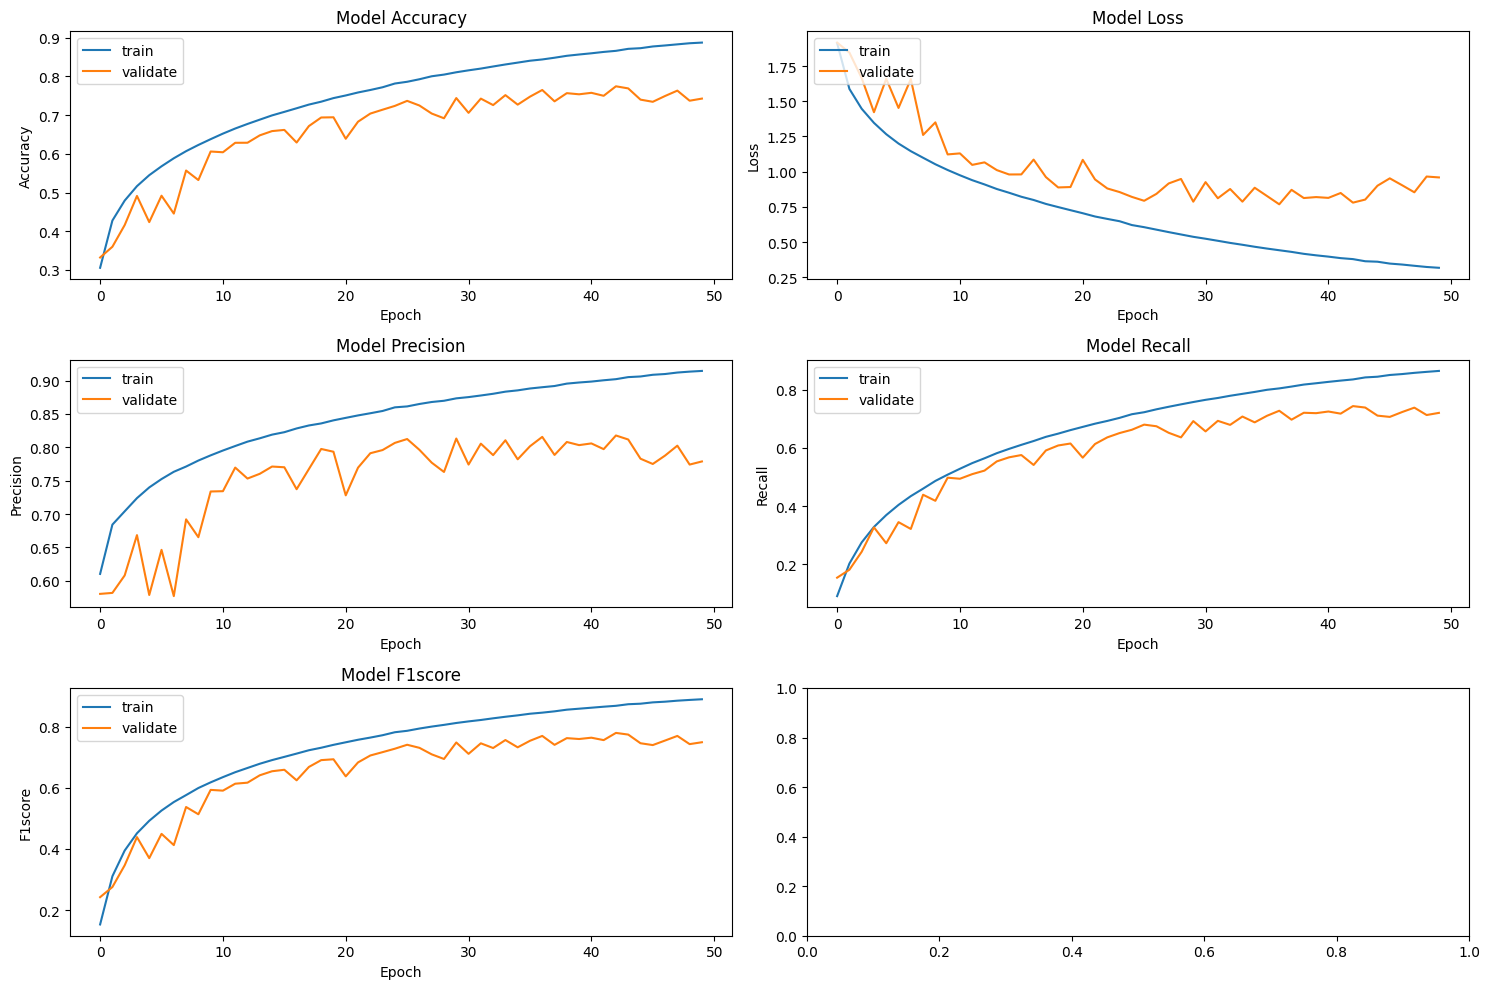

In [30]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [31]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  4.160170555114746
Accuracy of test set is:  0.35034313797950745
F1score of test set is:  0.3434319794178009
Precision of test set is:  0.3586188852787018
Recall of test set is:  0.3309633731842041


### Save parameter and matrix


In [35]:
label = list ((dict_data.keys()))
label

['right little',
 'right middle',
 'right ring',
 'right thumb',
 'right index',
 'left little',
 'left middle',
 'left ring',
 'left thumb',
 'left index']

In [36]:
label_me = np.array(label)
label_me

array(['right little', 'right middle', 'right ring', 'right thumb',
       'right index', 'left little', 'left middle', 'left ring',
       'left thumb', 'left index'], dtype='<U12')

In [44]:
np.save('/content/drive/MyDrive/X_train.npy', X_train)
np.save('/content/drive/MyDrive/X_val.npy', X_val)
np.save('/content/drive/MyDrive/X_test.npy', X_test)
np.save('/content/drive/MyDrive/Y_train.npy', Y_train)
np.save('/content/drive/MyDrive/Y_val.npy', Y_val)
np.save('/content/drive/MyDrive/Y_test.npy', Y_test)
np.save('/content/drive/MyDrive/label.npy', label_me)

In [46]:
from keras.models import save_model

# Lưu model vào thư mục chính trên Colab (thường là '/content/')
save_model(model, '/content/drive/MyDrive/resnet_18_pretrained', save_format='tf')

In [47]:
# Lưu trọng số vào file
model.save_weights('/content/drive/MyDrive/resnet_18_pretrained_weights.h5')


### Draw confusion matrix

9244/9244 [==============================] - 45s 5ms/step


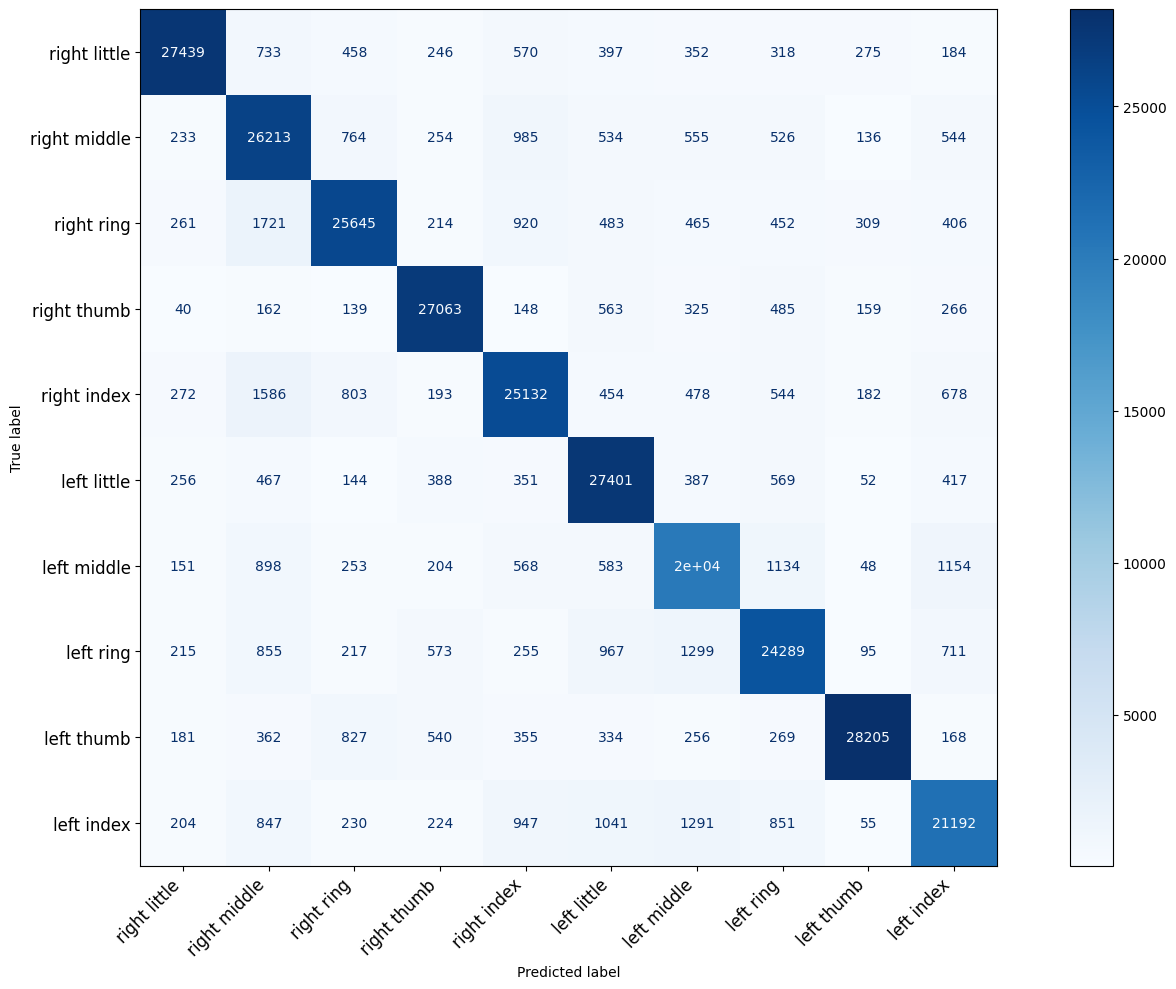

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(dict_data.keys())
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [52]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((295791, 16, 16, 1), (295791, 10), (85970, 16, 16, 1), (85970, 10))

2687/2687 [==============================] - 13s 5ms/step


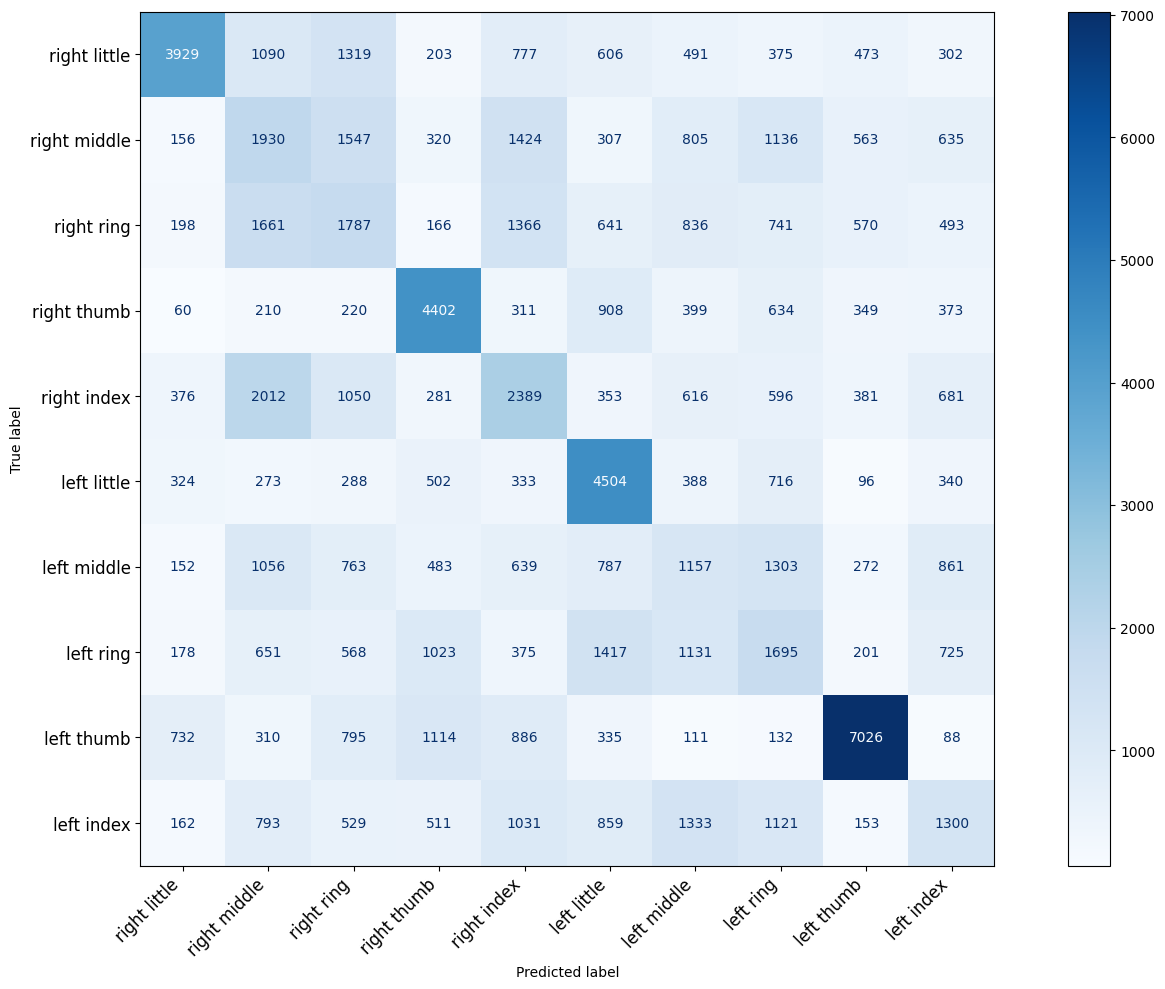

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(dict_data.keys())
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
